# Minimum Wage Simulation -- Estimator Comparisons



In [1]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')

from codes.simulation_functions import *

## Section 1: Compare Cengiz, Naive Percentile, and Hazard Estimators

In [88]:

# Function to apply Cengiz method for employment changes and wage effects
def cengiz_method(log_wages, m_pre, m_post, P_o=0.2, P_b=0, P_s=0.5):
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # Define the median of the pre-wage distribution (Wbar)
    Wbar = df_pre['real_wages'].median()

    bin_width = 0.25

    # Assign bins for pre and post data, excluding unemployed
    bins_pre = np.arange(0, Wbar + bin_width, bin_width)
    bins_post = np.arange(0, Wbar + bin_width, bin_width)

    df_pre['wage_bin'] = pd.cut(df_pre['real_wages'], bins=bins_pre, right=False)
    df_post['wage_bin'] = pd.cut(df_post['real_wages'], bins=bins_post, right=False)

    # Calculate the pre-period average wage of workers below the initial minimum wage
    affected_pre = df_pre[df_pre['original_log_wages'] < m_pre]
    # affected_post = df_post[df_post['original_log_wages'] < m_pre]

    average_affected_wage_pre = affected_pre['real_wages'].mean()
    affected_wage_bill_pre = affected_pre['real_wages'].sum()
    total_wage_bill_pre = df_pre['real_wages'].sum()
    total_wage_bill_post = df_post['real_wages'].sum()
    Δtotal_wage_bill = total_wage_bill_post - total_wage_bill_pre
    
    # Count the number of workers in each wage bin, excluding unemployed
    pre_counts = df_pre['wage_bin'].value_counts().sort_index()
    post_counts = df_post['wage_bin'].value_counts().sort_index()

    # count the total number of affected worker in the pre-period using affected_pre
    total_affected_pre = affected_pre.shape[0]

    pre_counts = pre_counts.reindex_like(post_counts).fillna(0)
    post_counts = post_counts.reindex_like(pre_counts).fillna(0)

    # Create a boolean mask for intervals where the left edge is greater than or equal to m_post
    mask_post = np.array([interval.left >= np.exp(m_post) for interval in post_counts.index])
    mask_pre = np.array([interval.left >= np.exp(m_post) for interval in pre_counts.index])

    # Calculate excess and missing jobs, only considering bins below Wbar
    Δa = post_counts[mask_post].sum() - pre_counts[mask_pre].sum()
    Δb = post_counts[~mask_post].sum() - pre_counts[~mask_pre].sum()
    Δemp = Δa + Δb

    total_employed_pre = pre_counts.sum()

    Δm = np.exp(m_post) - np.exp(m_pre)
    employment_elasticity = (Δemp / total_employed_pre) / (Δm / np.exp(m_pre))

    # change in total employment over the "affected workers" in the pre-period
    affected_employment_change = Δemp / total_affected_pre

    # change in wage bills of affected workers is the pre-period affected wage bill + the total change in wage bill of all workers
    affected_new_wage_bill = affected_wage_bill_pre + Δtotal_wage_bill
    affected_employment_post = total_affected_pre + Δemp

    # calculate percentage change in the average wage of affected workers
    new_average_wage_affected = affected_new_wage_bill / affected_employment_post

    # calculate percentage change in the average wage of affected workers
    percentage_change_average_wage_affected = (new_average_wage_affected - average_affected_wage_pre) / average_affected_wage_pre

    # calculate own_elasticity 
    own_wage_elasticity = affected_employment_change / percentage_change_average_wage_affected

    return {
        'employment_elasticity': employment_elasticity,
        'own_wage_elasticity': own_wage_elasticity,
        'percentage_change_affected_employment': affected_employment_change,
        'percentage_change_average_wage_affected': percentage_change_average_wage_affected,
        'Δa': Δa,
        'Δb': Δb,
        'bins_pre': pre_counts.index.tolist(),
        'pre_counts': pre_counts,
        'post_counts': post_counts
    }

# Example usage
log_wages = generate_log_wages(1000)  
result = cengiz_method(log_wages, np.log(10), np.log(12))
print(result)

{'employment_elasticity': -0.3238866396761137, 'own_wage_elasticity': -7.572486147446853, 'percentage_change_affected_employment': -0.16161616161616163, 'percentage_change_average_wage_affected': 0.021342549655327173, 'Δa': 142, 'Δb': -174, 'bins_pre': [Interval(0.0, 0.25, closed='left'), Interval(0.25, 0.5, closed='left'), Interval(0.5, 0.75, closed='left'), Interval(0.75, 1.0, closed='left'), Interval(1.0, 1.25, closed='left'), Interval(1.25, 1.5, closed='left'), Interval(1.5, 1.75, closed='left'), Interval(1.75, 2.0, closed='left'), Interval(2.0, 2.25, closed='left'), Interval(2.25, 2.5, closed='left'), Interval(2.5, 2.75, closed='left'), Interval(2.75, 3.0, closed='left'), Interval(3.0, 3.25, closed='left'), Interval(3.25, 3.5, closed='left'), Interval(3.5, 3.75, closed='left'), Interval(3.75, 4.0, closed='left'), Interval(4.0, 4.25, closed='left'), Interval(4.25, 4.5, closed='left'), Interval(4.5, 4.75, closed='left'), Interval(4.75, 5.0, closed='left'), Interval(5.0, 5.25, closed

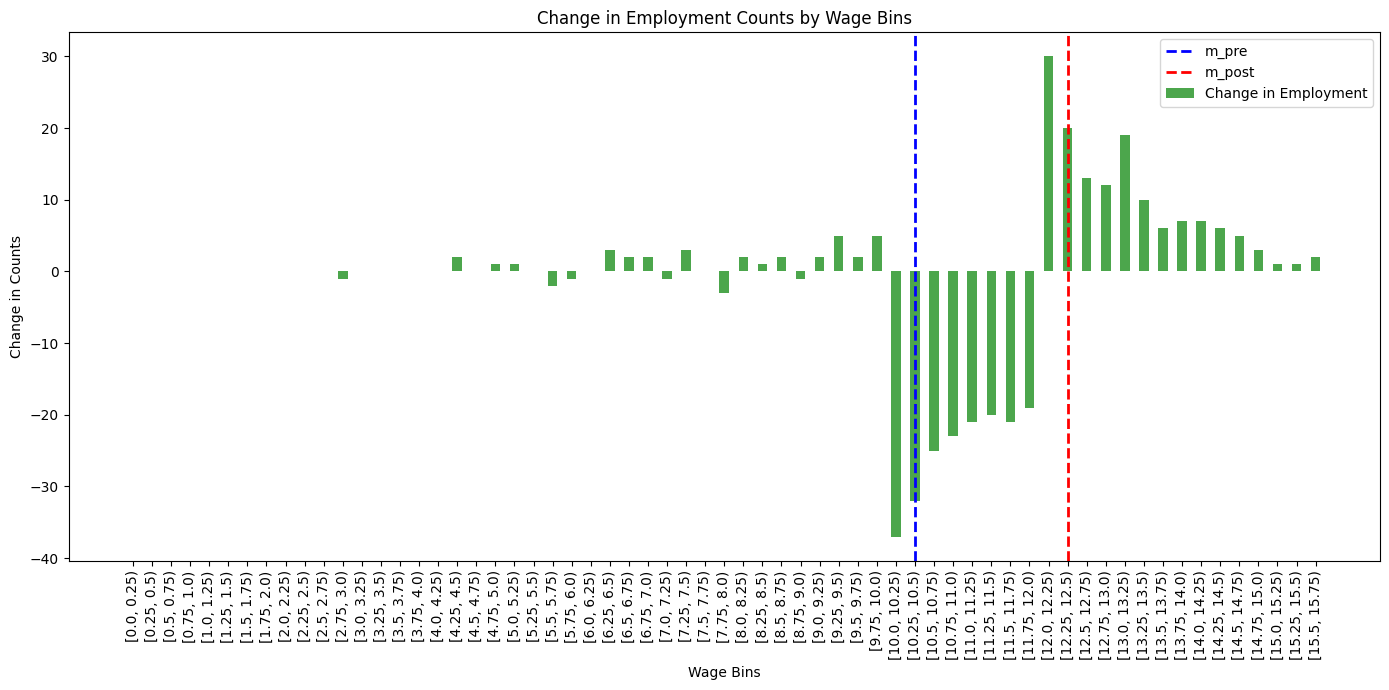

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming cengiz_method and generate_log_wages functions are defined as provided earlier

def plot_changes_in_employment(result, m_pre, m_post):
    pre_counts = result['pre_counts']
    post_counts = result['post_counts']
    bins_pre = result['bins_pre']

    # Calculate the changes in employment
    employment_changes = post_counts - pre_counts

    # Extract intervals for display
    intervals = [str(interval) for interval in bins_pre]

    bar_width = 0.5
    index = np.arange(len(intervals))

    plt.figure(figsize=(14, 7))
    plt.bar(index, employment_changes, bar_width, alpha=0.7, color='green', label='Change in Employment')

    plt.xlabel('Wage Bins')
    plt.ylabel('Change in Counts')
    plt.title('Change in Employment Counts by Wage Bins')
    plt.xticks(index, intervals, rotation=90)

    # Add m_pre and m_post lines
    plt.axvline(np.digitize(np.exp(m_pre), [interval.left for interval in bins_pre]), color='blue', linestyle='--', linewidth=2, label='m_pre')
    plt.axvline(np.digitize(np.exp(m_post), [interval.left for interval in bins_pre]), color='red', linestyle='--', linewidth=2, label='m_post')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate log wages for 1000 workers for testing purposes
def generate_log_wages(n):
    np.random.seed(42)
    return np.random.normal(np.log(15), 0.5, n)

log_wages = generate_log_wages(1000)  
result = cengiz_method(log_wages, np.log(10), np.log(12))
plot_changes_in_employment(result, np.log(10), np.log(12))


In [89]:
result['Δa']


142

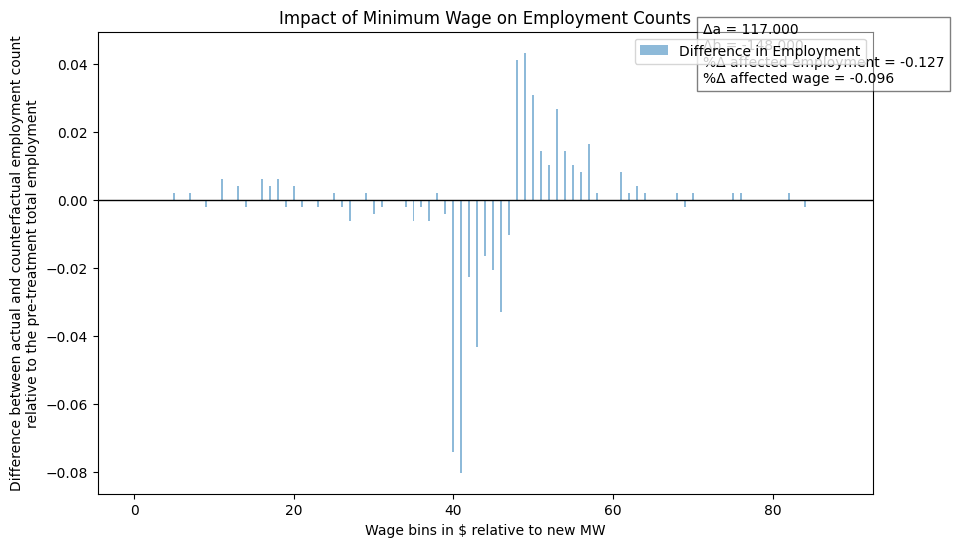

In [77]:
def plot_employment_differences(result):
    bins_pre = result['bins_pre']
    pre_counts = result['pre_counts']
    post_counts = result['post_counts']
    Δa = result['Δa']
    Δb = result['Δb']
    percentage_change_affected_employment = result['percentage_change_affected_employment']
    percentage_change_average_wage_affected = result['percentage_change_average_wage_affected']

    employment_difference = post_counts - pre_counts

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(bins_pre)), employment_difference / pre_counts.sum(), width=0.25, alpha=0.5, label='Difference in Employment')
    plt.axhline(0, color='black', linewidth=1)
    plt.xlabel('Wage bins in $ relative to new MW')
    plt.ylabel('Difference between actual and counterfactual employment count\nrelative to the pre-treatment total employment')
    plt.title('Impact of Minimum Wage on Employment Counts')
    plt.legend()
    plt.text(len(bins_pre) * 0.8, max(employment_difference / pre_counts.sum()) * 0.8,
             f'Δa = {Δa:.3f}\nΔb = {Δb:.3f}\n%Δ affected employment = {percentage_change_affected_employment:.3f}\n%Δ affected wage = {percentage_change_average_wage_affected:.3f}',
             bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# Example usage
plot_employment_differences(result)


# define naive percentile function


In [29]:

# Function to apply Cengiz method for employment changes and wage effects
def cengiz_method(log_wages, m_pre, m_post, P_o=0.2, P_b=0, P_s=0.5):
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # Define the median of the pre-wage distribution (Wbar)
    Wbar = df_pre['real_wages'].median()

    bin_width = 0.25

    # Assign bins for pre and post data, excluding unemployed
    bins_pre = np.arange(0, Wbar + bin_width, bin_width)
    bins_post = np.arange(0, Wbar + bin_width, bin_width)

    df_pre['wage_bin'] = pd.cut(df_pre['real_wages'], bins=bins_pre, right=False)
    df_post['wage_bin'] = pd.cut(df_post['real_wages'], bins=bins_post, right=False)

    # Calculate the pre-period average wage of workers below the initial minimum wage
    affected_pre = df_pre[df_pre['original_log_wages'] < m_pre]
    # affected_post = df_post[df_post['original_log_wages'] < m_pre]

    average_affected_wage_pre = affected_pre['real_wages'].mean()
    affected_wage_bill_pre = affected_pre['real_wages'].sum()
    total_wage_bill_pre = df_pre['real_wages'].sum()
    total_wage_bill_post = df_post['real_wages'].sum()
    Δtotal_wage_bill = total_wage_bill_post - total_wage_bill_pre
    
    # Count the number of workers in each wage bin, excluding unemployed
    pre_counts = df_pre['wage_bin'].value_counts().sort_index()
    post_counts = df_post['wage_bin'].value_counts().sort_index()

    # count the total number of affected worker in the pre-period using affected_pre
    total_affected_pre = affected_pre.shape[0]

    pre_counts = pre_counts.reindex_like(post_counts).fillna(0)
    post_counts = post_counts.reindex_like(pre_counts).fillna(0)

    # Calculate excess and missing jobs, only considering bins below Wbar
    Δa = post_counts.loc[df_post['wage_bin'].categories >= m_post].sum() - pre_counts.loc[df_pre['wage_bin'].categories >= m_post].sum()
    Δb = pre_counts.loc[df_pre['wage_bin'].categories < m_pre].sum() - post_counts.loc[df_post['wage_bin'].categories < m_pre].sum()
    Δemp = Δa + Δb

    total_employed_pre = pre_counts.sum()
    directly_affected_pre = pre_counts.loc[df_pre['wage_bin'].categories < m_post].sum()

    Δm = np.exp(m_post) - np.exp(m_pre)
    employment_elasticity = (Δemp / total_employed_pre) / (Δm / np.exp(m_pre))

    # change in total employment over the "affected workers" in the pre-period
    affected_employment_change = Δemp / directly_affected_pre

    # change in wage bills of affected workers is the pre-period affected wage bill + the total change in wage bill of all workers
    affected_new_wage_bill = affected_wage_bill_pre + Δtotal_wage_bill
    affected_employment_post = total_affected_pre + Δemp

    # calculate percentage change in the average wage of affected workers
    new_average_wage_affected = affected_new_wage_bill / affected_employment_post

    # calculate percentage change in the average wage of affected workers
    percentage_change_average_wage_affected = (new_average_wage_affected - average_affected_wage_pre) / average_affected_wage_pre

    return {
        'employment_elasticity': employment_elasticity,
        'percentage_change_affected_employment': affected_employment_change,
        'percentage_change_average_wage_affected': percentage_change_average_wage_affected,
        'Δa': Δa,
        'Δb': Δb,
        'bins_pre': pre_counts.index.tolist(),
        'pre_counts': pre_counts.values,
        'post_counts': post_counts.values
    }

# Example usage
log_wages = generate_log_wages(1000)  
result = cengiz_method(log_wages, np.log(10), np.log(12))
print(result)







AttributeError: 'Series' object has no attribute 'categories'

In [30]:
#define cengiz estimators for this simulation


In [ ]:

total_employed_pre = pre_counts.sum()
directly_affected_pre = pre_counts[~mask_pre].sum()

Δm = np.exp(m_post) - np.exp(m_pre)
employment_elasticity = (Δemp / total_employed_pre) / (Δm / np.exp(m_pre))

# change in total employment over the "affected workers" in the pre-period
affected_employment_change = Δemp / directly_affected_pre

# change in wage bills of affected workers is the pre-period affected wage bill + the total change in wage bill of all workers
affected_new_wage_bill = affected_wage_bill_pre + Δtotal_wage_bill
affected_employment_post = total_affected_pre + Δemp

# calculate percentage change in the average wage of affected workers
new_average_wage_affected = affected_new_wage_bill / affected_employment_post

# calculate percentage change in the average wage of affected workers
percentage_change_average_wage_affected = (new_average_wage_affected - average_affected_wage_pre) / average_affected_wage_pre
